이미지 스크래퍼 라이브러리
https://joedockrill.github.io/jmd_imagescraper/

In [1]:
!pip install -q jmd_imagescraper #이미지 스크래퍼 라이브러리 설치

In [2]:
from pathlib import Path
from jmd_imagescraper.core import * 
from jmd_imagescraper.imagecleaner import *
import os, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

## 0. 데이터 수집 및 전처리

In [3]:
base_dir = "/content/images"
num_images_per_class = 200 #클래스 별 이미지 개수
#num_images_per_class = 1000 #클래스 별 이미지 개수

#아래에서 "폴더명"과 "검색 키워드"를 각각 설정하여 다양한 클래스의 이미지를 수집합니다.
#res = duckduckgo_search(base_dir, "폴더명", "검색 키워드", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Moon", "Moon", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Earth", "Earth", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Mercury", "Mercury", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Venus", "Venus", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Sun", "Sun", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Mars", "Mars", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Milky way", "Milky way in the night sky", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Jupiter", "Jupiter", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Saturn", "Saturn", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Uranus", "Uranus", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Neptune", "Neptune", max_results=num_images_per_class, uuid_names=False)
res = duckduckgo_search(base_dir, "Aurora", "aurora in the night sky", max_results=num_images_per_class, uuid_names=False)

Duckduckgo search: Moon


Duckduckgo search: Earth


Duckduckgo search: Mercury


Duckduckgo search: Venus


Exception occured while retrieving https://tse1.mm.bing.net/th?id=OIP.mxFRk93K9DLJkpnrbHpmkgHaGl&pid=Api
Duckduckgo search: Sun


Exception occured while retrieving https://tse4.mm.bing.net/th?id=OIP.ty5-4BeOH_bA-MBGklIwwAHaHa&pid=Api
Duckduckgo search: Mars


Duckduckgo search: Milky way in the night sky


Duckduckgo search: Jupiter


Duckduckgo search: Saturn


Duckduckgo search: Uranus


Duckduckgo search: Neptune


Duckduckgo search: aurora in the night sky


In [ ]:
#팁: 데이터 수집이 잘못된 경우 아래 명령어를 실행하여 다운받은 이미지 폴더 전체 또는 하위 폴더를 제거할 수 있습니다.

#!rm -rf /content/images #다운로드 받은 이미지 폴더(base_dir의 주소) 전체 제거
#!rm -rf /content/images/Cats #다운로드 받은 이미지 폴더에서 "폴더명"에 해당하는 폴더 전체 제거

In [4]:
#다운받은 이미지를 확인하며 필요한 경우 노이즈를 제거합니다. 
display_image_cleaner(base_dir)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [56]:
class_names = ["Moon", "Earth", "Mercury", "Venus", "Sun", "Mars", "Milky way", "Aurora", "Jupiter", "Saturn", "Uranus", "Neptune"] # 다운받은 이미지 종류(클래스) 이름 지정 - 폴더명과 일치 확인

In [59]:
# 훈련, 검증, 테스트 분할을 위한 폴더 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for class_name in class_names:
  train_class_dir = os.path.join(train_dir, class_name)
  os.mkdir(train_class_dir)

  validation_class_dir = os.path.join(validation_dir, class_name)
  os.mkdir(validation_class_dir)

  test_class_dir = os.path.join(test_dir, class_name)
  os.mkdir(test_class_dir)

FileExistsError: ignored

In [7]:
#데이터를 훈련/검정/테스트 폴더로 분배

num_train = int(num_images_per_class*0.6) #전체 데이터의 60%를 훈련 데이터로
num_valid = int(num_images_per_class*0.2) #전체 데이터의 20%를 검증 데이터로
num_test = int(num_images_per_class*0.2) #전체 데이터의 20%를 테스트 데이터로

#각 파일명 앞의 "0" 제거
for class_name in class_names:
  class_dir = os.path.join(base_dir, class_name)
  for filename in os.listdir(class_dir):
    org_filename = os.path.join(class_dir,filename)
    new_filename = os.path.join(class_dir,filename.lstrip("0"))
    os.rename(org_filename, new_filename)

#훈련 데이터를 train 폴더에 복사
for class_name in class_names:
  class_dir = os.path.join(base_dir, class_name)
  train_class_dir =  os.path.join(train_dir, class_name)
  fnames = ['{}.jpg'.format(i+1) for i in range(num_train)]
  for fname in fnames:
    src = os.path.join(class_dir, fname)
    dst = os.path.join(train_class_dir, fname)
    if os.path.isfile(src):
      shutil.copyfile(src, dst)

#검증 데이터를 valid 폴더에 복사
for class_name in class_names:
  class_dir = os.path.join(base_dir, class_name)
  valid_class_dir =  os.path.join(validation_dir, class_name)
  fnames = ['{}.jpg'.format(i+1) for i in range(num_train, num_train+num_valid)]
  for fname in fnames:
    src = os.path.join(class_dir, fname)
    dst = os.path.join(valid_class_dir, fname)
    if os.path.isfile(src):
      shutil.copyfile(src, dst)

#테스트 데이터를 test 폴더에 복사
for class_name in class_names:
  class_dir = os.path.join(base_dir, class_name)
  test_class_dir =  os.path.join(test_dir, class_name)
  fnames = ['{}.jpg'.format(i+1) for i in range(num_train+num_valid, num_train+num_valid+num_test)]
  for fname in fnames:
    src = os.path.join(class_dir, fname)
    dst = os.path.join(test_class_dir, fname)
    if os.path.isfile(src):
      shutil.copyfile(src, dst)

In [8]:
#데이터셋 제네레이터 정의

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32)

Found 1056 images belonging to 12 classes.
Found 254 images belonging to 12 classes.
Found 238 images belonging to 12 classes.


In [9]:
#미니 배치 데이터 크기 및 레이블 크기 확인
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (32, 150, 150, 3)
배치 레이블 크기: (32, 12)


## 1. 모델 생성

In [50]:
#model = ....

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))
model.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5)) #드랍아웃 적용
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='softmax'))

#팁: 입력 데이터의 모양이 (150,150,3)과 동일한지, 최종 출력층의 크기가 클래스 개수와 동일한지 확인합니다.

## 2. 모델 컴파일

In [51]:
#model.compile(....)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#팁: loss는 'categorical_crossentropy'를 사용합니다 (데이터셋 제네레이터는 기본적으로 클래스 종류가 여러개인 상황인 'categorical'로 정의되어 있음)

## 3. 모델 학습

In [52]:
#history = model.fit(...)

history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator)

#팁: 미리 정의해 둔 훈련 제네레이터와 검증 제네레이터를 사용합니다.

Epoch 1/30
33/33 [==============================] - 5s 139ms/step - loss: 2.0116 - accuracy: 0.3153 - val_loss: 1.8254 - val_accuracy: 0.3858
Epoch 2/30
33/33 [==============================] - 4s 132ms/step - loss: 1.3662 - accuracy: 0.5502 - val_loss: 1.4948 - val_accuracy: 0.5236
Epoch 3/30
33/33 [==============================] - 4s 132ms/step - loss: 1.0930 - accuracy: 0.6402 - val_loss: 1.4171 - val_accuracy: 0.5827
Epoch 4/30
33/33 [==============================] - 4s 134ms/step - loss: 0.8205 - accuracy: 0.7358 - val_loss: 1.3937 - val_accuracy: 0.5591
Epoch 5/30
33/33 [==============================] - 4s 133ms/step - loss: 0.6668 - accuracy: 0.7888 - val_loss: 1.2835 - val_accuracy: 0.6181
Epoch 6/30
33/33 [==============================] - 4s 132ms/step - loss: 0.5551 - accuracy: 0.8220 - val_loss: 1.2714 - val_accuracy: 0.6850
Epoch 7/30
33/33 [==============================] - 4s 133ms/step - loss: 0.4446 - accuracy: 0.8504 - val_loss: 1.6590 - val_accuracy: 0.6181
Epoch 

## 4. 결과 확인

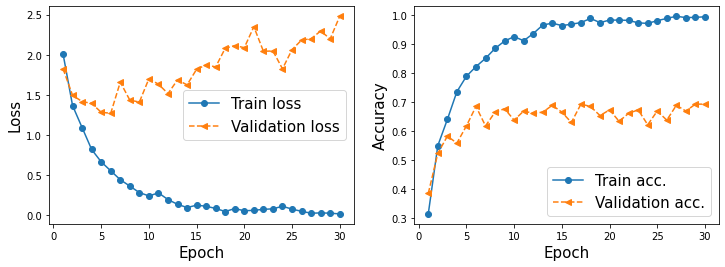

In [53]:
#에폭 진행에 따른 손실과 정확도를 확인합니다.
 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [54]:
#테스트 데이터 정확도를 확인합니다.

test_results = model.evaluate(test_generator)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

8/8 [==============================] - 1s 94ms/step - loss: 3.9540 - accuracy: 0.5294

테스트 정확도 52.94%


In [60]:
from tensorflow.keras.preprocessing import image

x, y =  test_generator.next()
p = model.predict(x)

for i in range(len(p)):
  print("true: ",y[i])
  print("predicted: ",[np.round(k, 2) for k in p[i]])
  plt.imshow(image.array_to_img(x[i]))
  plt.show()
  print()


Output hidden; open in https://colab.research.google.com to view.

## 5. 추가 미션
 - 모델 구조 변경, 데이터 증식, 전이 학습 등을 적용해 테스트 정확도를 올려 볼 수 있습니다.
 - 학습된 모델에서 입력 이미지의 어떤 부분이 강조되었는지 시각화를 진행해 볼 수 있습니다.